<a href="https://colab.research.google.com/github/lililalina/ibmds-eda-for-ml/blob/main/01d_DEMO_Feature_Engineering2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Foundation

## Section 1, Part d: Feature Engineering 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Feature Engineering with Linear Regression: Applied to the Ames Housing Data

Using the Ames Housing Data:

Dean De Cock
Truman State University
Journal of Statistics Education Volume 19, Number 3(2011), www.amstat.org/publications/jse/v19n3/decock.pdf

In this notebook, we will build some linear regression models to predict housing prices from this data. In particular, we will set out to improve on a baseline set of features via **feature engineering**: deriving new features from our existing data. Feature engineering often makes the difference between a weak model and a strong one.

We will use visual exploration, domain understanding, and intuition to construct new features that will be useful later in the course as we turn to prediction.

**Notebook Contents**

> 1. Simple EDA 
> 2. One-hot Encoding variables
> 3. Log transformation for skewed variables
> 4. Pair plot for features
> 5. Basic feature engineering: adding polynomial and interaction terms
> 6. Feature engineering: categories and features derived from category aggregates 

## 1. Simple EDA 

In [ ]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
sns.set()

Populating the interactive namespace from numpy and matplotlib


#### Load the Data, Examine and Explore

In [ ]:
## Load in the Ames Housing Data
datafile = "/content/drive/MyDrive/Colab Notebooks/IBM Data Science 04 - EDA for Machine Learning/Ames_Housing_Data.tsv"
df = pd.read_csv(datafile, sep='\t')

In [ ]:
## Examine the columns, look at missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [ ]:
# This is recommended by the data set author to remove a few outliers

df = df.loc[df['Gr Liv Area'] <= 4000,:]
print("Number of rows in the data:", df.shape[0])
print("Number of columns in the data:", df.shape[1])
data = df.copy() # Keep a copy our original data 

Number of rows in the data: 2925
Number of columns in the data: 82


In [ ]:
# A quick look at the data:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


We're going to first do some basic data cleaning on this data: 

* Converting categorical variables to dummies
* Making skew variables symmetric

### One-hot encoding for dummy variables:

In [ ]:
# Get a Pd.Series consisting of all the string categoricals
one_hot_encode_cols = df.dtypes[df.dtypes == np.object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

df[one_hot_encode_cols].head().T #T is an addition to transpose the dataframe

,0,1,2,3,4


We're going to first do some basic data cleaning on this data: 

* Converting categorical variables to dummies
* Making skew variables symmetric

#### One-hot encoding the dummy variables:

In [ ]:
# Do the one hot encoding
df = pd.get_dummies(df, columns=one_hot_encode_cols, drop_first=True)
df

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning_C (all),...,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_RFn,Garage Finish_Unf,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_Po,Garage Qual_TA,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_Po,Garage Cond_TA,Paved Drive_P,Paved Drive_Y,Pool QC_Fa,Pool QC_Gd,Pool QC_TA,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,1,526301100,20,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,1960.0,2.0,528.0,210,62,0,0,0,0,0,5,2010,215000,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2,526350040,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,105000,0,...,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,3,526351010,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,172000,0,...,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,4,526353030,20,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,1968.0,2.0,522.0,0,0,0,0,0,0,0,4,2010,244000,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,5,527105010,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010,189900,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,37.0,7937,6,6,1984,1984,0.0,819.0,0.0,184.0,1003.0,1003,0,0,1003,1.0,0.0,1,0,3,1,6,0,1984.0,2.0,588.0,120,0,0,0,0,0,0,3,2006,142500,0,...,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2926,2927,923276100,20,NaN,8885,5,5,1983,1983,0.0,301.0,324.0,239.0,864.0,902,0,0,902,1.0,0.0,1,0,2,1,5,0,1983.0,2.0,484.0,164,0,0,0,0,0,0,6,2006,131000,0,...,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2927,2928,923400125,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,912.0,970,0,0,970,0.0,1.0,1,0,3,1,6,0,NaN,0.0,0.0,80,32,0,0,0,0,700,7,2006,132000,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2928,2929,924100070,20,77.0,10010,5,5,1974,1975,0.0,1071.0,123.0,195.0,1389.0,1389,0,0,1389,1.0,0.0,1,0,2,1,6,1,1975.0,2.0,418.0,240,38,0,0,0,0,0,4,2006,170000,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Order,2925.0,1.464795e+03,8.464417e+02,1.0,732.0,1463.0,2199.0,2.930000e+03
PID,2925.0,7.143931e+08,1.887274e+08,526301100.0,528477030.0,535453210.0,907180130.0,1.007100e+09
MS SubClass,2925.0,5.739658e+01,4.266875e+01,20.0,20.0,50.0,70.0,1.900000e+02
Lot Frontage,2435.0,6.902382e+01,2.271092e+01,21.0,58.0,68.0,80.0,3.130000e+02
Lot Area,2925.0,1.010358e+04,7.781999e+03,1300.0,7438.0,9428.0,11515.0,2.152450e+05
...,...,...,...,...,...,...,...,...
Sale Condition_AdjLand,2925.0,4.102564e-03,6.393067e-02,0.0,0.0,0.0,0.0,1.000000e+00
Sale Condition_Alloca,2925.0,8.205128e-03,9.022520e-02,0.0,0.0,0.0,0.0,1.000000e+00
Sale Condition_Family,2925.0,1.572650e-02,1.244366e-01,0.0,0.0,0.0,0.0,1.000000e+00
Sale Condition_Normal,2925.0,8.246154e-01,3.803608e-01,0.0,1.0,1.0,1.0,1.000000e+00


### Log transforming skew variables

In [ ]:
# Create a list of float colums to check for skewing
mask = data.dtypes == np.float
float_cols = data.columns[mask] #mask the data, only applied to float data type

skew_limit = 0.75 # define a limit above which we will log transform
skew_vals = data[float_cols].skew()

In [ ]:
example = skew_vals.sort_values(ascending = False).to_frame().rename(columns={0:'Skew'})
example.query('abs(Skew) > {}'.format(skew_limit))

,Skew
BsmtFin SF 2,4.135900
Bsmt Half Bath,3.965970
Mas Vnr Area,2.565458
Lot Frontage,1.111071
Bsmt Unf SF,0.925021
BsmtFin SF 1,0.821985


In [ ]:
# Showing the skewed columns
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols

,Skew
BsmtFin SF 2,4.135900
Bsmt Half Bath,3.965970
Mas Vnr Area,2.565458
Lot Frontage,1.111071
Bsmt Unf SF,0.925021
BsmtFin SF 1,0.821985


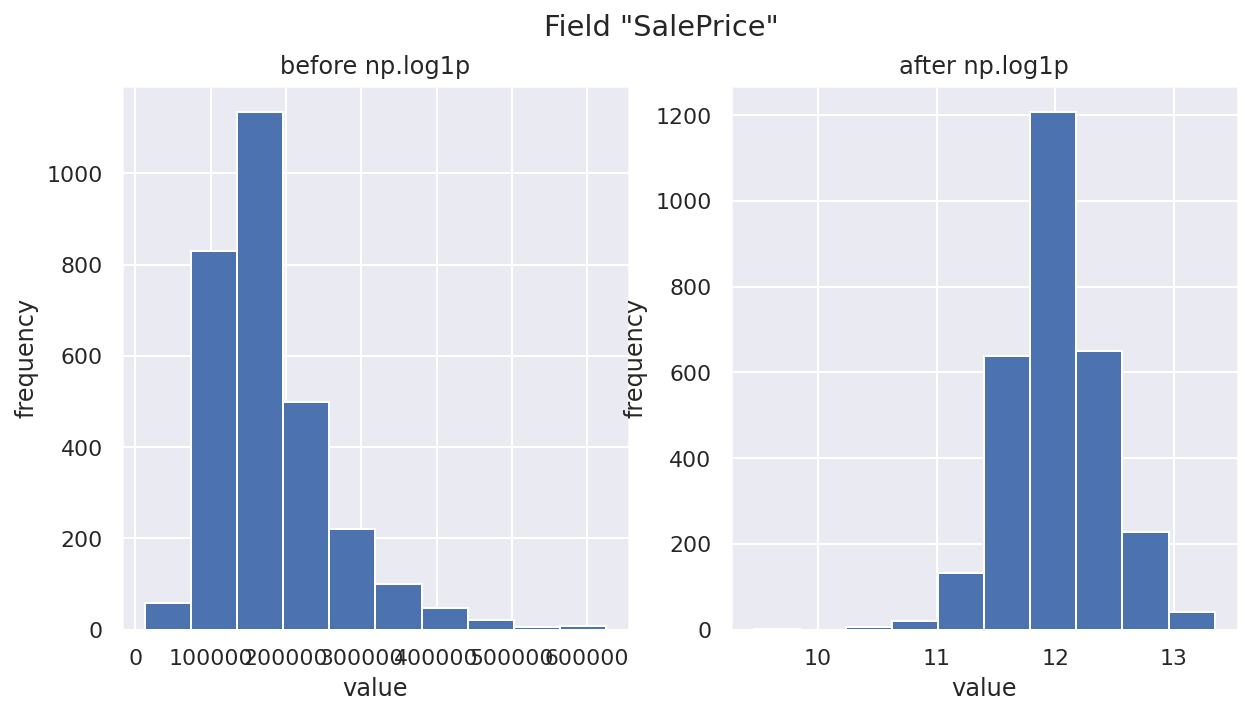

In [ ]:
# Let's look at what happens to one of these features, when we apply np.log1p visually.

# Choose a field
field = "SalePrice"

# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
df[field].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
df[field].apply(np.log1p).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));

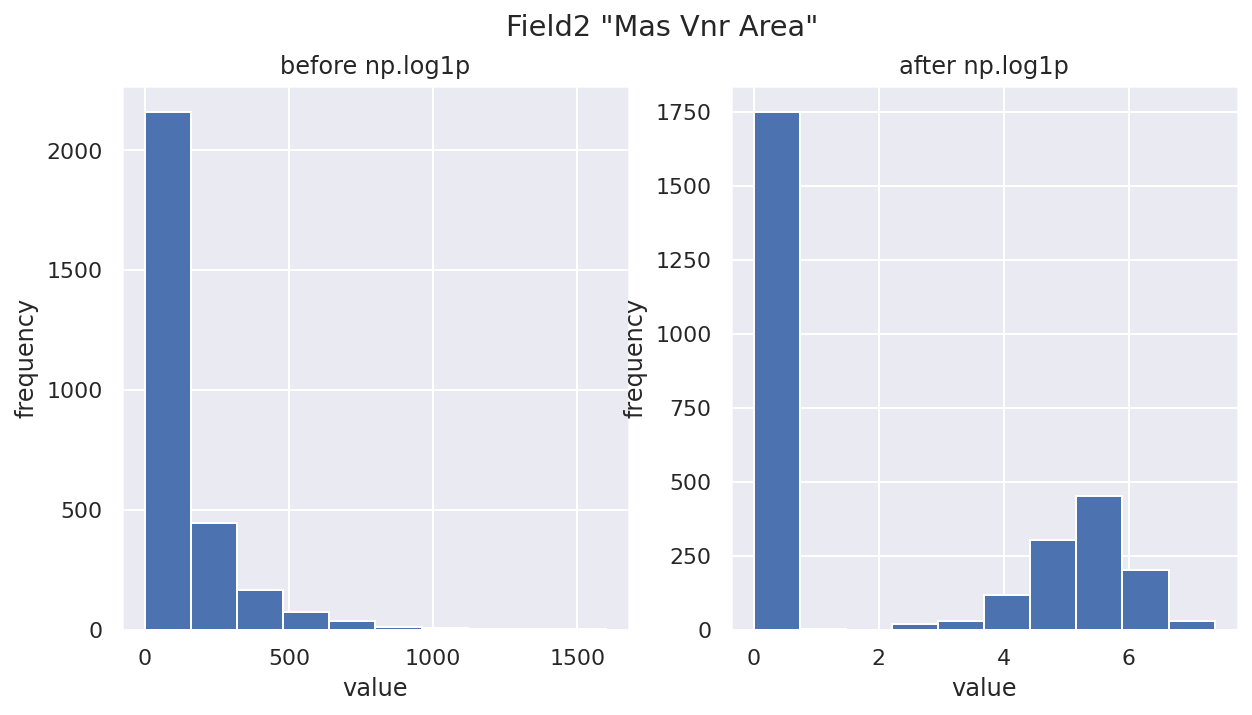

In [ ]:
#Example for other variables

# Choose a field
field2 = "Mas Vnr Area"

#Create two subplots and a figure using matplotlib
fig, (ax2_before, ax2_after) = plt.subplots(1,2, figsize = (10,5))

#Create a histogram on the "ax2_before" subplot
df[field2].hist(ax = ax2_before)

# The distribution is quite skewed left, so let's try a transformation first
df[field2].apply(np.log1p).hist(ax=ax2_after)

# We see it doesn't make any difference so, yeah..
# Anyway let's try formatting it
ax2_before.set(title = 'before np.log1p', ylabel = 'frequency', xlabel = 'value')
ax2_after.set(title = 'after np.log1p', ylabel = 'frequency', xlabel = 'value')
fig.suptitle('Field2 "{}"'.format(field2));

In [ ]:
# Perform the skew transformation:

for col in skew_cols.index.values:
    if col == "SalePrice":
        continue
    df[col] = df[col].apply(np.log1p)

In [ ]:
# We now have a larger set of potentially-useful features
df.shape

(2925, 262)

In [ ]:
# There are a *lot* of variables. Let's go back to our saved original data and look at how many values are missing for each variable. 
df = data
data.isnull().sum().sort_values()

Order                0
Sale Condition       0
Heating QC           0
Central Air          0
1st Flr SF           0
                  ... 
Fireplace Qu      1422
Fence             2354
Alley             2727
Misc Feature      2820
Pool QC           2914
Length: 82, dtype: int64

 Let's pick out just a few numeric columns to illustrate basic feature transformations.

In [ ]:
smaller_df= df.loc[:,['Lot Area', 'Overall Qual', 'Overall Cond', 
                      'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
                      'Full Bath', 'Bedroom AbvGr', 'Fireplaces', 
                      'Garage Cars','SalePrice']]

In [ ]:
# Now we can look at summary statistics of the subset data
smaller_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Lot Area,2925.0,10103.583590,7781.999124,1300.0,7438.0,9428.0,11515.0,215245.0
Overall Qual,2925.0,6.088205,1.402953,1.0,5.0,6.0,7.0,10.0
Overall Cond,2925.0,5.563761,1.112262,1.0,5.0,5.0,6.0,9.0
Year Built,2925.0,1971.302906,30.242474,1872.0,1954.0,1973.0,2001.0,2010.0
Year Remod/Add,2925.0,1984.234188,20.861774,1950.0,1965.0,1993.0,2004.0,2010.0
Gr Liv Area,2925.0,1493.978803,486.273646,334.0,1126.0,1441.0,1740.0,3820.0
Full Bath,2925.0,1.564786,0.551386,0.0,1.0,2.0,2.0,4.0
Bedroom AbvGr,2925.0,2.853675,0.827737,0.0,2.0,3.0,3.0,8.0
Fireplaces,2925.0,0.596923,0.645349,0.0,0.0,1.0,1.0,4.0
Garage Cars,2924.0,1.765048,0.759834,0.0,1.0,2.0,2.0,5.0


In [ ]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Bedroom AbvGr   2925 non-null   int64  
 8   Fireplaces      2925 non-null   int64  
 9   Garage Cars     2924 non-null   float64
 10  SalePrice       2925 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 354.2 KB


In [ ]:
# There appears to be one NA in Garage Cars - we will take a simple approach and fill it with 0
smaller_df = smaller_df.fillna(0)

In [ ]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Bedroom AbvGr   2925 non-null   int64  
 8   Fireplaces      2925 non-null   int64  
 9   Garage Cars     2925 non-null   float64
 10  SalePrice       2925 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 354.2 KB



### Pair plot of features
Now that we have a nice, filtered dataset, let's generate visuals to better understand the target and feature-target relationships: pairplot is great for this!

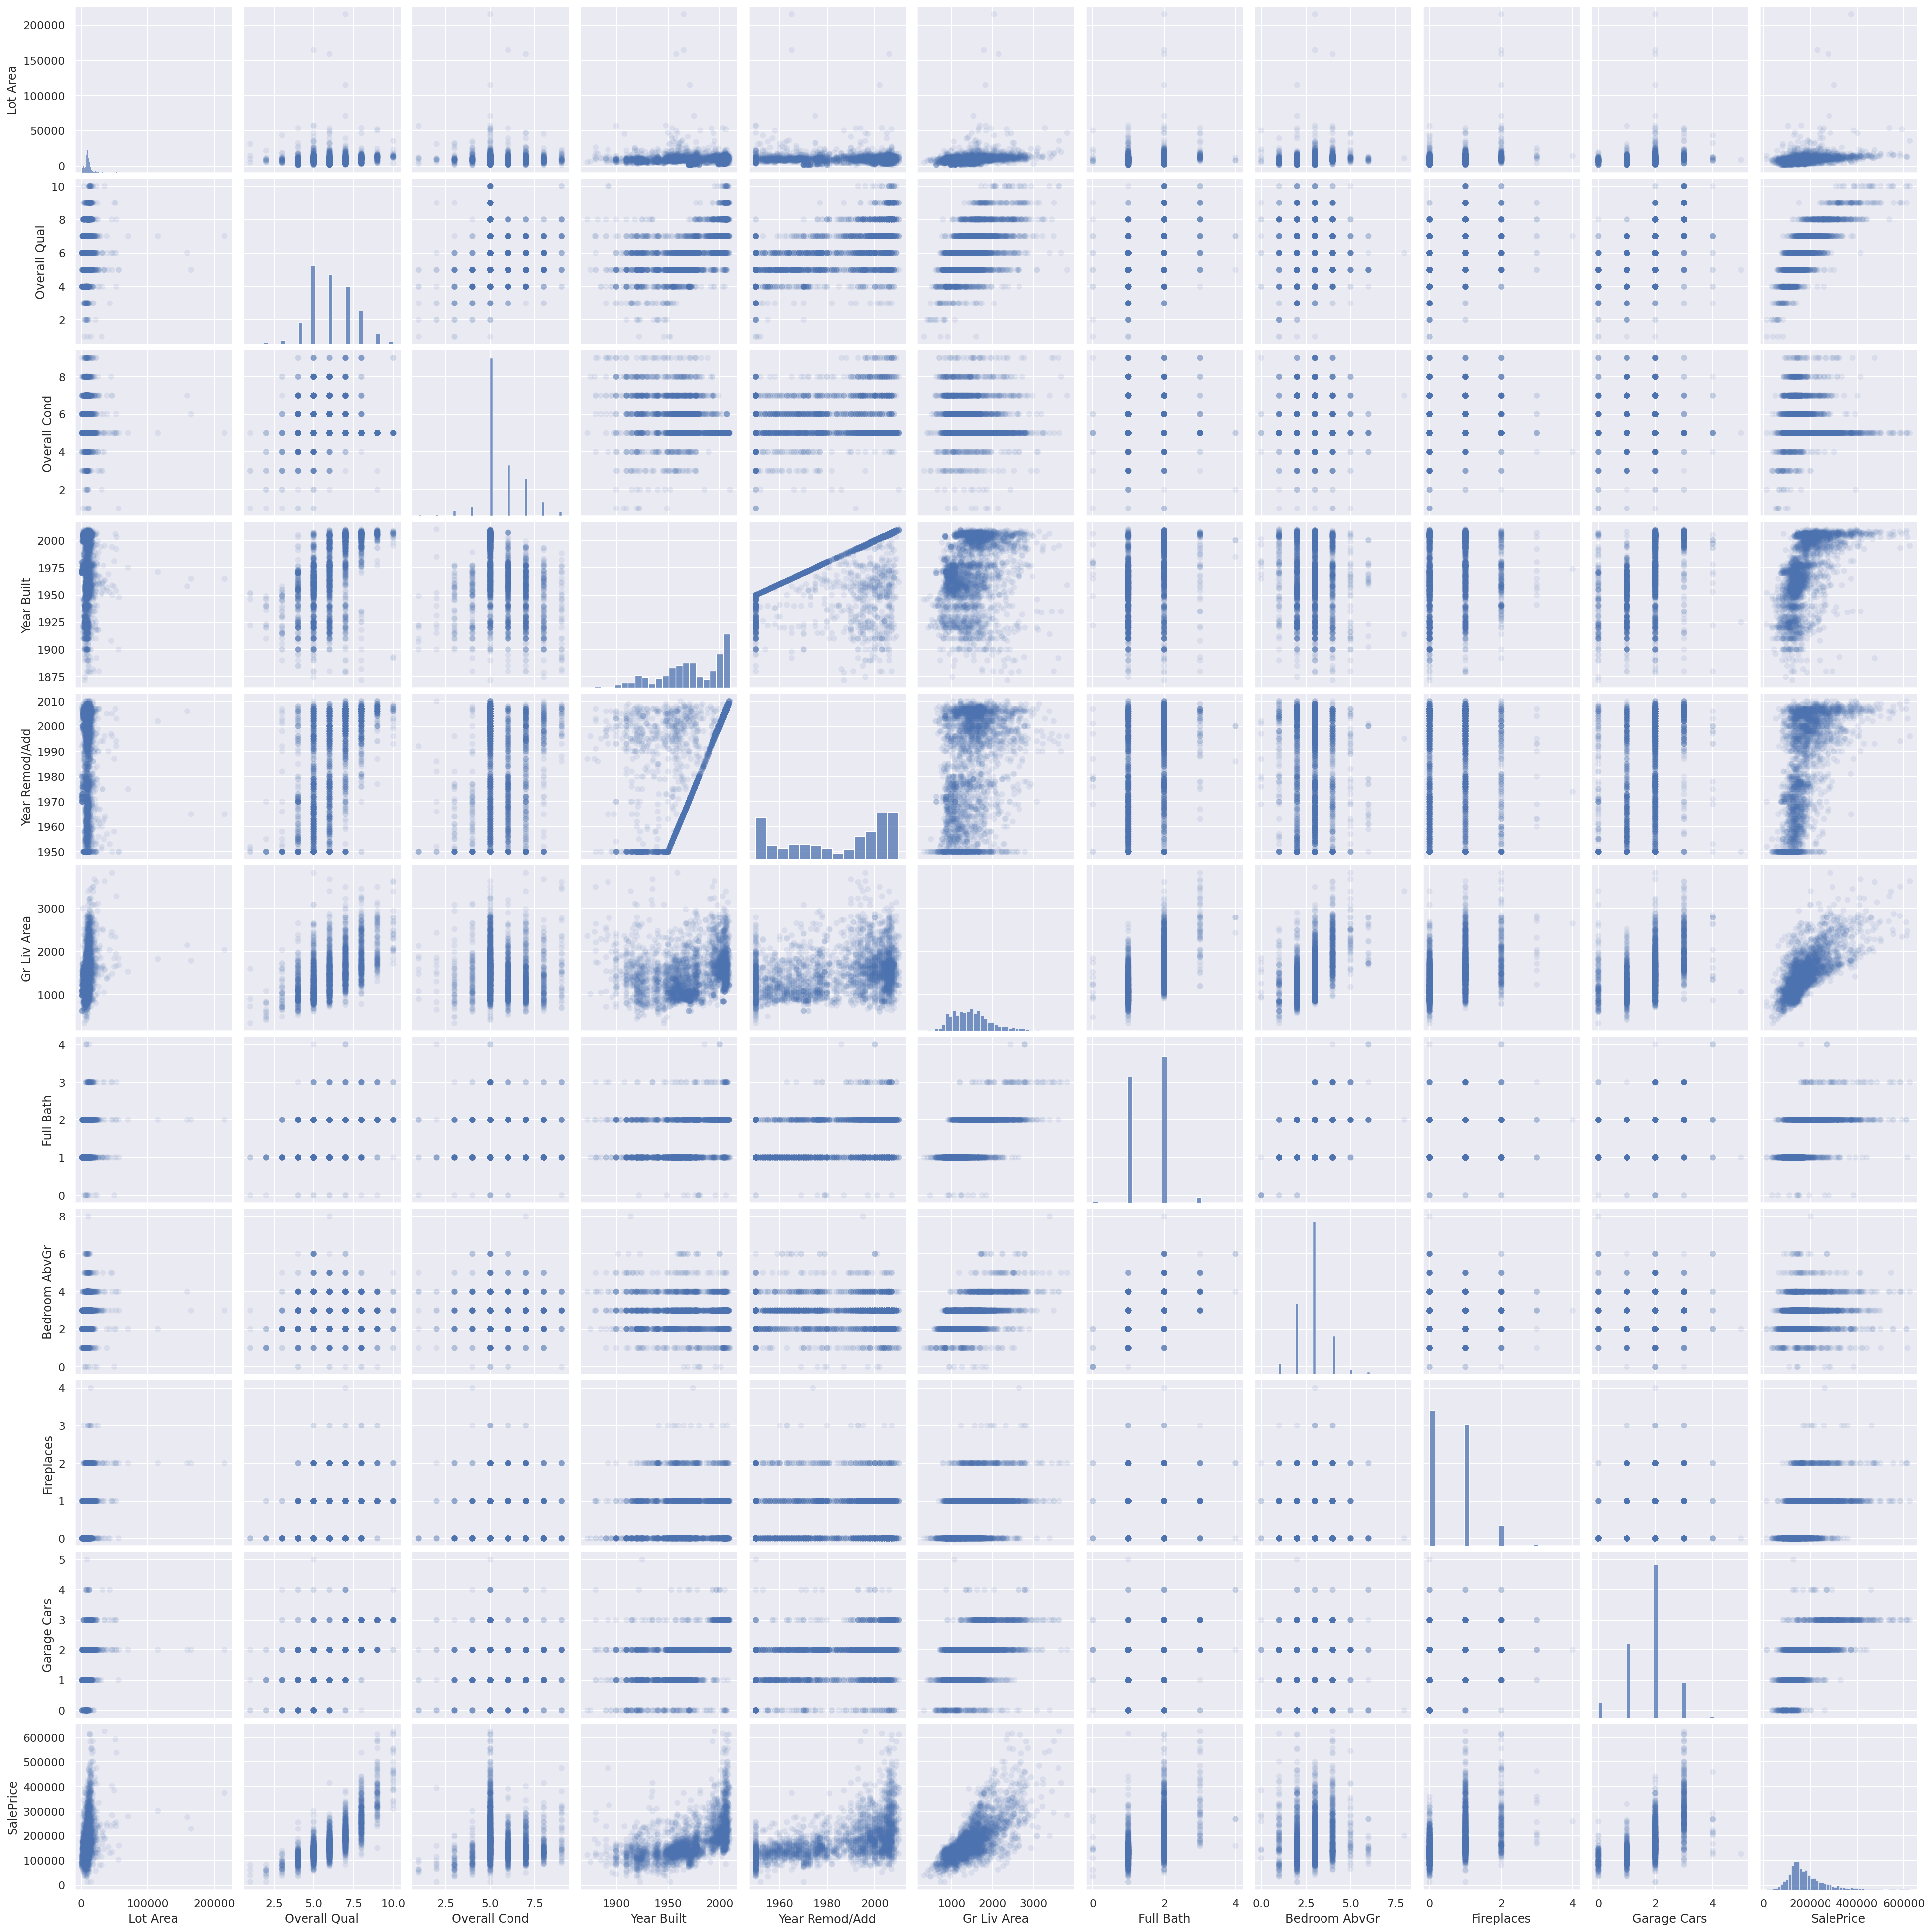

In [ ]:
sns.pairplot(smaller_df, plot_kws=dict(alpha=.1, edgecolor='none'))

---
**Data Exploration Discussion**: 

1. What do these plots tell us about the distribution of the target?   

2. What do these plots tell us about the relationship between the features and the target? Do you think that linear regression is well-suited to this problem? Do any feature transformations come to mind?

3. What do these plots tell us about the relationship between various pairs of features? Do you think there may be any problems here? 

---

#### Suppose our target variable is the SalePrice. We can set up separate variables for features and target.

In [ ]:
#Separate our features from our target

X = smaller_df.loc[:,['Lot Area', 'Overall Qual', 'Overall Cond', 
                      'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
                      'Full Bath', 'Bedroom AbvGr', 'Fireplaces', 
                      'Garage Cars']]

y = smaller_df['SalePrice']

In [ ]:
X.info()

Now that we have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a **train/validation split** before we fit and score the model. 

Since we'll be repeatedly splitting X, y into the same train/val partitions and fitting/scoring new models as we update our feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

Great, let's go ahead and run this function on our baseline feature set and take some time to analyze the results.

### Basic feature engineering: adding polynomial and interaction terms

One of the first things that we looked for in the pairplot was evidence about the relationship between each feature and the target. In certain features like _'Overall Qual'_ and _'Gr Liv Qual'_, we notice an upward-curved relationship rather than a simple linear correspondence. This suggests that we should add quadratic **polynomial terms or transformations** for those features, allowing us to express that non-linear relationship while still using linear regression as our model.

Luckily, pandas makes it quite easy to quickly add those square terms as additional features to our original feature set. We'll do so and evaluate our model again below.

As we add to our baseline set of features, we'll create a copy of the latest benchmark so that we can continue to store our older feature sets. 
### Polynomial Features

In [ ]:
X2 = X.copy()

X2['OQ2'] = X2['Overall Qual'] ** 2
X2['GLA2'] = X2['Gr Liv Area'] ** 2


As is, each feature is treated as an independent quantity. However, there may be **interaction effects**, in which the impact of one feature may dependent on the current value of a different feature.

For example, there may be a higher premium for increasing _'Overall Qual'_ for houses that were built more recently. If such a premium or a similar effect exists, a feature that multiplies _'Overall Qual'_ by _'Year Built'_ can help us capture it.

Another style of interaction term involves feature proprtions: for example, to get at something like quality per square foot we could divide _'Overall Qual'_ by _'Lot Area'_.

Let's try adding both of these interaction terms and see how they impact the model results.

### Feature interactions

In [ ]:
X3 = X2.copy()

# multiplicative interaction
X3['OQ_x_YB'] = X3['Overall Qual'] * X3['Year Built']

# division interaction
X3['OQ_/_LA'] = X3['Overall Qual'] / X3['Lot Area']



-----
**Interaction Feature Exercise**: What other interactions do you think might be helpful? Why? 

-----

### Categories and features derived from category aggregates 

Incorporating **categorical features** into linear regression models is fairly straightforward: we can create a new feature column for each category value, and fill these columns with 1s and 0s to indicate which category is present for each row. This method is called **dummy variables** or **one-hot-encoding**.

We'll first explore this using the _'House Style'_ feature from the original dataframe. Before going straight to dummy variables, it's a good idea to check category counts to make sure all categories have reasonable representation.

In [ ]:
data['House Style'].value_counts()

This looks ok, and here's a quick look at how dummy features actually appear:

In [ ]:
pd.get_dummies(df['House Style'], drop_first=True).head()

We can call `pd.get_dummies()` on our entire dataset to quickly get data with all the original features and dummy variable representation of any categorical features. Let's look at some variable values.

In [ ]:
nbh_counts = df.Neighborhood.value_counts()
nbh_counts

For this category, let's map the few least-represented neighborhoods to an "other" category before adding the feature to our feature set and running a new benchmark.

In [ ]:
other_nbhs = list(nbh_counts[nbh_counts <= 8].index)

other_nbhs

In [ ]:
X4 = X3.copy()

X4['Neighborhood'] = df['Neighborhood'].replace(other_nbhs, 'Other')


#### Getting to fancier features

Let's close out our introduction to feature engineering by considering a more complex type of feature that may work very nicely for certain problems. It doesn't seem to add a great deal over what we have so far, but it's a style of engineering to keep in mind for the future.

We'll create features that capture where a feature value lies relative to the members of a category it belongs to. In particular, we'll calculate deviance of a row's feature value from the mean value of the category that row belongs to. This helps to capture information about a feature relative to the category's distribution, e.g. how nice a house is relative to other houses in its neighborhood or of its style.

Below we define reusable code for generating features of this form, feel free to repurpose it for future feature engineering work!

In [ ]:
def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create category means and standard deviations for each observation
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature  

And now let's use our feature generation code to add 2 new deviation features, and run a final benchmark.

In [ ]:
X5 = X4.copy()
X5['House Style'] = df['House Style']
add_deviation_feature(X5, 'Year Built', 'House Style')
add_deviation_feature(X5, 'Overall Qual', 'Neighborhood')


## Polynomial Features in Scikit-Learn

`sklearn` allows you to build many higher-order terms at once with `PolynomialFeatures`

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
#Instantiate and provide desired degree; 
#   Note: degree=2 also includes intercept, degree 1 terms, and cross-terms

pf = PolynomialFeatures(degree=2)

In [ ]:
features = ['Lot Area', 'Overall Qual']
pf.fit(df[features])

In [ ]:
pf.get_feature_names()  #Must add input_features = features for appropriate names

In [ ]:
feat_array = pf.transform(df[features])
pd.DataFrame(feat_array, columns = pf.get_feature_names(input_features=features))

## Recap

While we haven't yet turned to prediction, these feature engineering exercises set the stage. Generally, feature engineering often follows a sort of [_Pareto principle_](https://en.wikipedia.org/wiki/Pareto_principle), where a large bulk of the predictive gains can be reached through adding a set of intuitive, strong features like polynomial transforms and interactions. Directly incorporating additional information like categorical variables can also be very helpful. Beyond this point, additional feature engineering can provide significant, but potentially diminishing returns. Whether it's worth it depends on the use case for the model. 

---
### Machine Learning Foundation (C) 2020 IBM Corporation